# Use self-joins with panel data to improve model accuracy 

Author: Andrea Kropp
Version date: May 2023

## Overview

The intended audience for this notebooks is data scientists in nearly all industries, especially those who work with panel data.

### When to use self-joins

Panel data contains multiple observations for consistent subjects over time. Those subjects can be persons, companies, products, locations, or any other discrete categorical unit. Examples of panel data dimensions are present in nearly every industry. Below are three examples of panel dimensions:

* Customers: Customer interaction data over multiple time-intervals
* Zip codes: Historical attributes of homes for sale in various zip codes 
* Lakes: Water quality measures from various lakes

Panel data often exists in multiple tables, such as having a customer table and a seperate transaction table, as covered in [this AI accelerator](https://github.com/datarobot-community/ai-accelerators/tree/main/advanced-experimentation/AFD "End-to-End Automated Feature Discovery Workflow")
.  However, it is also common for singular datasets to have more than one feature which can be used as a panel dimensions. Consider a dataset of flight delays for various airline carriers, origin airports, and destination airports over time. The airline carrier, origin airport, and destination airport all fit the criteria of panel data subjects. In the case of only having one table of panel data, you can join the dataset _with itself_ using Feature Discovery to create lagged features over time. This is called the __self-join technique__.

When building predictive models from panel data, you can often improve the model substantially by including engineered features which capture time-based patterns within the panel feature(s). The extent to which this technique will improve accuracy for any specific use case requires experimentation and cannot be known at the outset.

This notebook uses airplane delays as they are a familiar phenomenon to many people. Examples of time-aware aggregations for this use case are:

* Average taxiing time by __origin airport__ across the last 3 days
* Minimum delay due to late aircraft arrival __by carrier__ in the last 3 days 
* Average total minutes of delays by __destination airport__ in the last 24 hours

The self-join technique generates these types of features automatically and uses them for modeling during Autopilot. Consider using the self-join technique any time that your dataset has date or datetime information for the same subject over time.

### Notebook contents

In this notebook you develop a model for predicting airline take-off delays of 30 minutes or more. The dataset has a least three features which qualify as panel features, namely the origin airport code (OA), the destination airport code (DA), and the airline carrier code (CC). 

The notebook shows you how to use the self-join technique multiple times using a single dataset. Specifically, you will register one dataset in the AICatalog and join it back onto itself four times.

The notebook assumes basic familiarity with running machine learning experiments in DataRobot. It focuses the self-join technique which requires careful consideration of feature lists and joining time-aware datasets. It also uses dataset aliases to improve human readability of the engineered feature names. The two feature lists will be named **Known Features** and **Self-Join Features**.

### Avoiding Target Leakage
In the data dictionary used in the notebook, there are numerous features which are not known at prediction time. These are all the subcategories for how many minutes of delay (the prediction target) came from taxiing, security, or waiting for an inbound aircraft. It is important that these features are not included in the feature list used to run Autopilot. 

At the same time, past values for these features could be very informative and helpful for the model. It is easy to imagine that aggregations such as the following could be immensely helpful in predicting take off delays for today's flights:

* Average taxiing time at a specific origin airport across the past three days
* Minimum delay due to late aircraft arrival by carrier in the last three days 
* Average total delays by destination airport across the last 24 hours


### Data source

Information on flight delays is made available by the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/ONTIME/Departures.aspx). DataRobot downloaded data from this website in April 2023 and made minor modifications to prepare it for use in this notebook. 

To narrow down the amount of data involved, the dataset assembled for this use case is limited to January 2023 flights originating in San Francisco (SFO), Portland (PDX), and Seattle (SEA) operated by the carriers Alaska Airlines (AS), American Airlines (AA), Hawaiian Airlines (HA), and United Airlines (UA). A flight was declared to be delayed if it ultimately took off at least thirty minutes after its scheduled departure time.
  
There 14,803 rows in the dataset with these 15 columns:

| Field                      | Data Type         | Description                                                                                           |
| -------------------------- | ----------------- | ----------------------------------------------------------------------------------------------------- |
| Date                       | str (MM/DD/YYYY) | The date of the flight                                                                                |
| Carrier Code               | categorical       | The carrier code of the airline (one of AS, AA, HA, UA)                                               |
| Origin Airport             | categorical       | The three-letter airport code of the origin airport (one of PDX, SEA, SFO)                            |
| Flight Number              | numeric           | The flight number for the flight (needs to be converted to categorical)                               |
| Tail Number                | categorical       | The tail number of the aircraft                                                                       |
| Destination Airport        | categorical       | The three-letter airport code of the destination airport (many variants)                              |
| Scheduled Departure Time   | time (HH:MM)      | The 24-hour scheduled departure time of the flight, in the origin airport's timezone                  |
| Take-Off Delay Minutes     | numeric           | The number of minutes past the scheduled departure time that the flight took off (also known as wheels-up time) |
| Take-Off Delay 30          | boolean           | Whether the flight was delayed at least 30 minutes (TARGET feature)                                    |
| Taxi Out Time              | numeric           | The number of minutes for taxiing before take-off                                                     |
| Delay Carrier              | numeric           | The number of minutes delay caused by the carrier                                                     |
| Delay Weather              | numeric           | The number of minutes delay caused by the weather                                                     |
| Delay National Aviation System | numeric        | The number of minutes delay caused by the National Aviation System                                    |
| Delay Security             | numeric           | The number of minutes delay caused by security                                                        |
| Delay Late Arrival Aircraft | numeric           | The number of minutes delay caused by a late-arriving aircraft       

## Setup

### Import libraries

The first cell of the notebook imports necessary packages, and sets up the connection to the DataRobot platform. 

In [1]:
import random

import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [2]:
api_key = "YOUR_API_TOKEN"  # Get this from the Developer Tools page in the DataRobot UI
endpoint = "YOUR_DATAROBOT_BASE_URL"  # eg "https://app.datarobot.com/" This should be the URL you use to access the DataRobot UI

dr.Client(endpoint="%sapi/v2" % (endpoint), token=api_key)

## Import data

The data for this use case is provided in an 800 KB CSV file in DataRobot's Amazon S3 public datasets bucket. You can [download the data](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/airline_delays_self_join.csv) to inspect it or add it directly to DataRobot's AI Catalog as shown in this notebook.

The dataset can be added to AI Catalog directly from the Amazon S3 bucket.

In [4]:
dataset = dr.Dataset.upload(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/airline_delays_self_join.csv"
)
data_id = dataset.id
data_id

'646c0e6f5d283c33054df69d'

## Explore the data

In this section, familairize yourself with the data. Begin by accessing the dataset uploaded to AI Catalog and converting it to a Pandas DataFrame. Then perform a few aggregations to see how the features you will use for the self-joins relate to delays.

### Retrieve and view dataset

In [5]:
# Retrieve the data set and convert it to a pandas dataframe
df = dr.Dataset.get(data_id).get_as_dataframe()
df.head(10)

,Date,Carrier_Code,Origin_Airport,Flight_Number,Tail_Number,Destination_Airport,Scheduled_Departure_Time,Take_Off_Delay_Minutes,Take_Off_Delay_30,Taxi_Out_Time,Delay_Carrier,Delay_Weather,Delay_National_Aviation_System,Delay_Security,Delay_Late_Aircraft_Arrival
0,1/1/23,UA,SEA,2090,N79521,ORD,0:29,3,0,14,0,0,0,0,0
1,1/1/23,AS,SEA,185,N408AS,ANC,0:30,75,1,13,51,0,0,0,0
2,1/1/23,AA,SEA,2748,N434AN,DFW,5:00,10,0,15,0,0,0,0,0
3,1/1/23,UA,SEA,2672,N67501,DEN,5:03,3,0,13,0,0,0,0,0
4,1/1/23,UA,PDX,2493,N39423,DEN,5:05,8,0,15,0,0,0,0,0
5,1/1/23,UA,SFO,583,N75426,IAH,5:15,15,0,19,0,0,0,0,0
6,1/1/23,UA,SFO,2426,N69885,DEN,5:25,20,0,16,0,0,0,0,0
7,1/1/23,AS,SFO,559,N453AS,SEA,6:00,18,0,18,0,0,0,0,0
8,1/1/23,AA,PDX,2216,N124AA,DFW,6:00,23,0,25,0,0,0,0,0
9,1/1/23,AA,SFO,1198,N139AN,DFW,6:00,12,0,18,0,0,0,0,0


Text(0.5, 0, 'Flight Count')

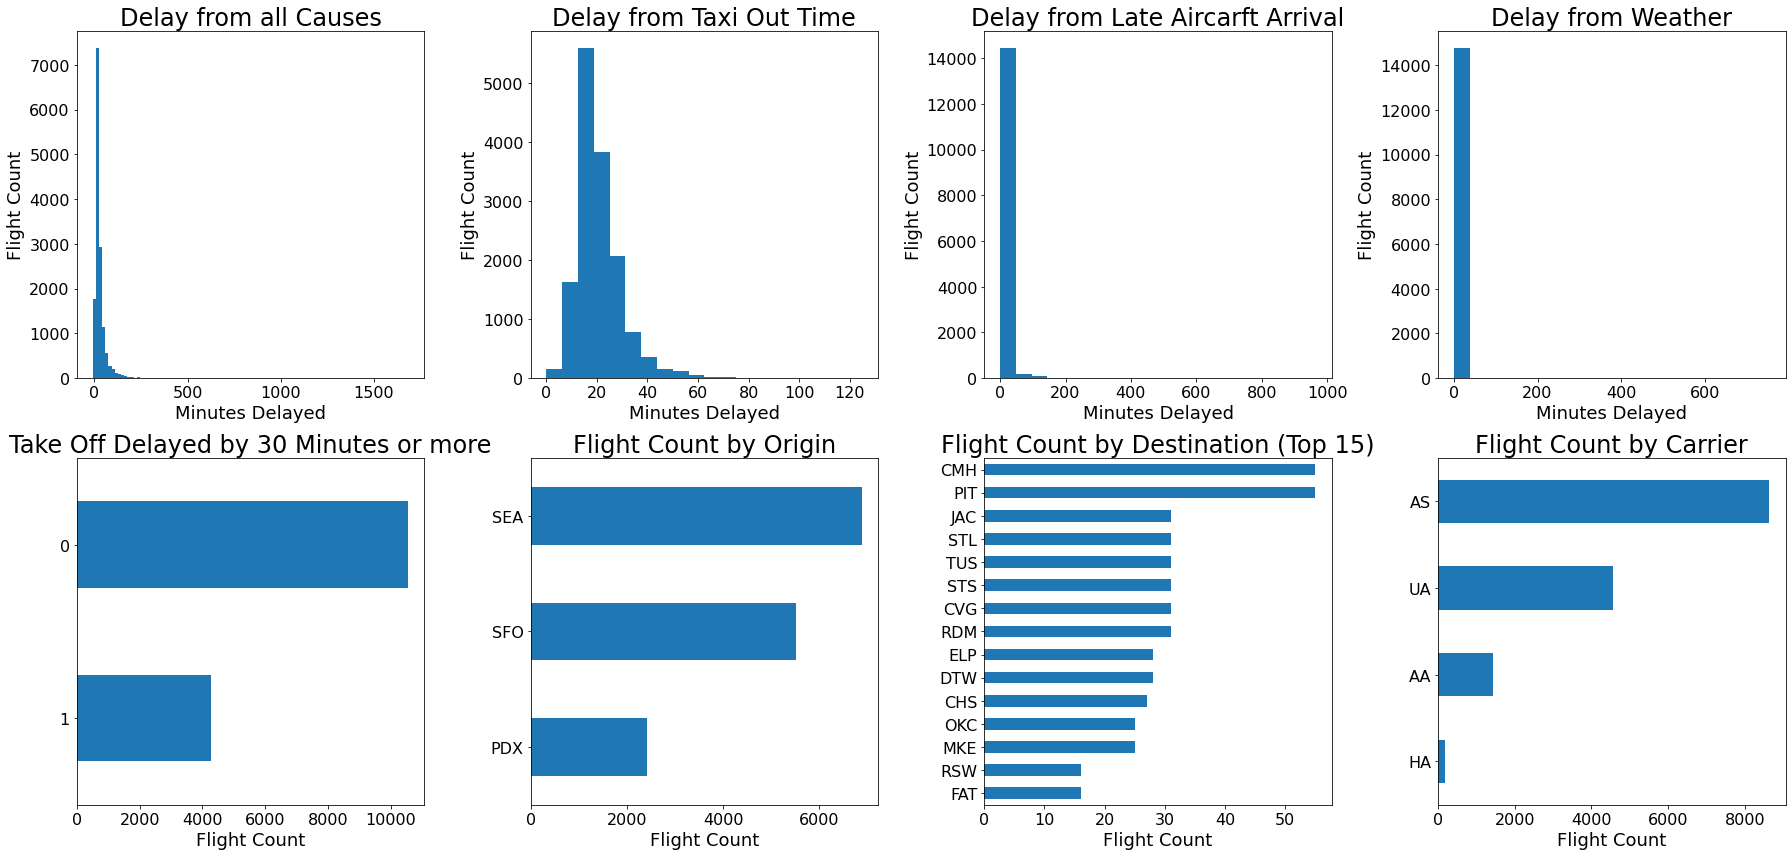

In [6]:
# Explore the structured data provided with some plots
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["figure.titlesize"] = 24

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 12), tight_layout=True)

plt.subplot(2, 4, 1)
plt.hist(df["Take_Off_Delay_Minutes"], bins=100)
plt.title(
    "Delay from all Causes",
)
plt.ylabel("Flight Count")
plt.xlabel("Minutes Delayed")

plt.subplot(2, 4, 2)
plt.hist(df["Taxi_Out_Time"], bins=20)
plt.title(
    "Delay from Taxi Out Time",
)
plt.ylabel("Flight Count")
plt.xlabel("Minutes Delayed")

plt.subplot(2, 4, 3)
plt.hist(df["Delay_Late_Aircraft_Arrival"], bins=20)
plt.title(
    "Delay from Late Aircarft Arrival",
)
plt.ylabel("Flight Count")
plt.xlabel("Minutes Delayed")

plt.subplot(2, 4, 4)
plt.hist(df["Delay_Weather"], bins=20)
plt.title(
    "Delay from Weather",
)
plt.ylabel("Flight Count")
plt.xlabel("Minutes Delayed")

plt.subplot(2, 4, 5)
df["Take_Off_Delay_30"].value_counts().sort_values().plot(kind="barh")
plt.title("Take Off Delayed by 30 Minutes or more")
plt.xlabel("Flight Count")

plt.subplot(2, 4, 6)
df["Origin_Airport"].value_counts().sort_values().plot(kind="barh")
plt.title("Flight Count by Origin")
plt.xlabel("Flight Count")

plt.subplot(2, 4, 7)
df["Destination_Airport"].value_counts().sort_values()[0:15].plot(kind="barh")
plt.title("Flight Count by Destination (Top 15)")
plt.xlabel("Flight Count")

plt.subplot(2, 4, 8)
df["Carrier_Code"].value_counts().sort_values().plot(kind="barh")
plt.title("Flight Count by Carrier")
plt.xlabel("Flight Count")

In [7]:
# Calculate the percentage of all flights delayed by more than 30 minutes
np.mean(df["Take_Off_Delay_30"])

0.2879146119029926

### Explore categorical features used for self-joins

In [8]:
# Summarize the delay data by carrier and origin airport
df2 = df.groupby(["Origin_Airport", "Carrier_Code"]).agg(
    flight_count=pd.NamedAgg(column="Flight_Number", aggfunc=len),
    delayed_count=pd.NamedAgg(column="Take_Off_Delay_30", aggfunc=sum),
    percent_delayed=pd.NamedAgg(column="Take_Off_Delay_30", aggfunc=np.mean),
    average_delayed_duration=pd.NamedAgg(
        column="Take_Off_Delay_Minutes", aggfunc=np.mean
    ),
)
df2

flight_count  delayed_count  percent_delayed  \
Origin_Airport Carrier_Code                                                 
PDX            AA                     231             32         0.138528   
               AS                    1692            236         0.139480   
               HA                      62             15         0.241935   
               UA                     425             67         0.157647   
SEA            AA                     432             77         0.178241   
               AS                    5801           1738         0.299604   
               HA                      68             14         0.205882   
               UA                     576            101         0.175347   
SFO            AA                     762            167         0.219160   
               AS                    1142            393         0.344133   
               HA                      62             22         0.354839   
               UA                    3550           1400         0.394366   

                             average_delayed_duration  
Origin_Airport Carrier_Code                            
PDX            AA                           27.164502  
               AS                           17.555556  
               HA                           53.661290  
               UA                           18.804706  
SEA            AA                           40.060185  
               AS                           27.823651  
               HA                           27.955882  
               UA                           25.755208  
SFO            AA                           34.688976  
               AS                           34.079685  
               HA                           56.580645  
               UA                           38.186479

In [9]:
# Summarize the delay data by destination airport
df3 = df.groupby(["Destination_Airport"]).agg(
    flight_count=pd.NamedAgg(column="Flight_Number", aggfunc=len),
    delayed_count=pd.NamedAgg(column="Take_Off_Delay_30", aggfunc=sum),
    percent_delayed=pd.NamedAgg(column="Take_Off_Delay_30", aggfunc=np.mean),
    average_delayed_duration=pd.NamedAgg(
        column="Take_Off_Delay_Minutes", aggfunc=np.mean
    ),
)
df3.head(10)

,flight_count,delayed_count,percent_delayed,average_delayed_duration
Destination_Airport,,,,
ABQ,93,29,0.311828,28.430108
ANC,478,142,0.297071,26.052301
ATL,98,38,0.387755,33.938776
AUS,275,88,0.320000,29.509091
BNA,83,38,0.457831,36.240964
BOI,63,21,0.333333,23.619048
BOS,270,107,0.396296,36.462963
BUR,176,34,0.193182,23.000000
BWI,62,21,0.338710,34.967742


## Add feature lists

In this section, add two new feature lists to the dataset uploaded to AI Catalog. This task can be done before or after a project is created. 

You will use self-joins with the same dataset __four times__. The two feature lists will be called 'Known Features' and 'Self-Join Features'. Adding the feature lists to AI Catalog avoids repeating this step for each of the four joins.

In the data dictionary, there are numerous features which are not known at prediction time. This includes the total delay in minutes and all the subcategories for how many minutes of delay came from taxiing, security or waiting for an inbound aircraft, etc. It is very important that these features are not included in the feature list used to run Autopilot. Many of these features may be flagged as having [target leakage](https://docs.datarobot.com/en/docs/data/analyze-data/data-quality.html#target-leakage).

At the same time, past values for these features could be very informative and helpful for the model. It is okay for these features to be in the Self-Join Features list because you will be adding a one day gap between the historical data and the prediction data when generating lagged features. __Notice also that the target feature 'Take_Off_Delay_30' is in the list of Self-Join Features__.

<p align="center">
  <img src="https://docs.datarobot.com/en/docs/images/safer-pp-0.png" alt="Alt Text" />
</p>
<p align="center">
  <em>In this use case, the gap between the cutoff and prediction point is 1 day. </em>
</p>

For more details, visit the [Feature Discovery Documentation](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-time.html#prediction-point-and-time-indexes)

### Create new feature lists

In [10]:
self_join_features = [
    "Carrier_Code",
    "Origin_Airport",
    "Flight_Number",
    "Tail_Number",
    "Destination_Airport",
    "Scheduled_Departure_Time",
    "Take_Off_Delay_Minutes",
    "Take_Off_Delay_30",
    "Taxi_Out_Time",
    "Delay_Carrier",
    "Delay_Weather",
    "Delay_National_Aviation_System",
    "Delay_Security",
    "Delay_Late_Aircraft_Arrival",
]

self_join_features_list = dataset.create_featurelist(
    name="Self_Join_Features", features=self_join_features
)

self_join_features_list_id = self_join_features_list.id
self_join_features_list_id

'646c0ea95d283c33054df6c0'

In [11]:
known_features = [
    "Carrier_Code",
    "Origin_Airport",
    "Flight_Number",
    "Tail_Number",
    "Destination_Airport",
    "Scheduled_Departure_Time",
]

known_features_list = dataset.create_featurelist(
    name="Known_Features", features=known_features
)

known_features_list_id = known_features_list.id
known_features_list_id

'646c0ea91a9478889f450f90'

In [12]:
# Check that the newly created feature lists are present
dataset.get_featurelists()

[DatasetFeaturelist(Informative Features),
 DatasetFeaturelist(universe),
 DatasetFeaturelist(Raw Features),
 DatasetFeaturelist(Known_Features),
 DatasetFeaturelist(Self_Join_Features)]

## Create a project and start modeling

To create a project from a dataset in the AI Catalog use `create_from_dataset()`.

Start a new project and obtain its ID number for future reference. You can optionally open the DataRobot GUI to see a new project listed after you execute the next cell.

In [13]:
project = dr.Project.create_from_dataset(
    dataset.id, project_name="Airline Delays Self Joins Notebook Demo"
)
project.id

'646c0eaa6c20cb10cb228e16'

In [14]:
# List the feature lists associated with the project

feature_lists_for_project = project.get_featurelists()
feature_lists_for_project

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Known_Features),
 Featurelist(Self_Join_Features)]

In [15]:
# Extract the known feature list ID for later use
primary_featurelist = [
    flist for flist in feature_lists_for_project if flist.name.find("Known") != -1
][0]
primary_featurelist_id = primary_featurelist.id
primary_featurelist_id

'646c0eb5f36ee3670e6e2280'

### Define self-join rules

In this section you define exactly how the dataset should be joined onto itself. Define four secondary data sets using `dr.DatasetDefinition()` because you want to self-join four times. Then define four relationships using `dr.Relationship()`.

In [16]:
# Define the relationships and join keys for the four secondary data sets (which are the same primary dataset over and over again)
# Note - we are using Self_Join_Features explicitly

# Define the secondary dataset named Carrier for Carrier Code
cc_secondary = dr.DatasetDefinition(
    identifier="Carrier",
    catalog_id=dataset.id,
    catalog_version_id=dataset.version_id,
    primary_temporal_key="Date",
    feature_list_id=self_join_features_list_id,
)

# Define the secondary dataset named Origin for Origin Airport
oa_secondary = dr.DatasetDefinition(
    identifier="Origin",
    catalog_id=dataset.id,
    catalog_version_id=dataset.version_id,
    primary_temporal_key="Date",
    feature_list_id=self_join_features_list_id,
)

# Define the secondary dataset named Destination for Destination Airport
da_secondary = dr.DatasetDefinition(
    identifier="Destination",
    catalog_id=dataset.id,
    catalog_version_id=dataset.version_id,
    primary_temporal_key="Date",
    feature_list_id=self_join_features_list_id,
)

# Define the secondary dataset named CCOA for Carrier Code - Origin Airport
ccoa_secondary = dr.DatasetDefinition(
    identifier="CCOA",
    catalog_id=dataset.id,
    catalog_version_id=dataset.version_id,
    primary_temporal_key="Date",
    feature_list_id=self_join_features_list_id,
)

In [17]:
# Define the relationship between the primary and Carrier data sets and the feature derivation windows (FDW) to test
# In this case, looking back 3 days and a 10 days ('start'), and leaving a 1 day gap between the prediction point ('end')
# This FDW is used for three of the secondary datasets and 14-day is used for the fourth dataset
# A maximum of three FDWs can be defined for each secondary dataset

cc_relationship = dr.Relationship(
    dataset2_identifier="Carrier",
    dataset1_keys=["Carrier_Code"],
    dataset2_keys=["Carrier_Code"],
    feature_derivation_windows=[
        {"start": -3, "end": -1, "unit": "DAY"},
        {"start": -10, "end": -1, "unit": "DAY"},
    ],
    prediction_point_rounding=1,
    prediction_point_rounding_time_unit="DAY",
)

# Define the relationship between the primary dataset and Origin
oa_relationship = dr.Relationship(
    dataset2_identifier="Origin",
    dataset1_keys=["Origin_Airport"],
    dataset2_keys=["Origin_Airport"],
    feature_derivation_windows=[
        {"start": -3, "end": -1, "unit": "DAY"},
        {"start": -10, "end": -1, "unit": "DAY"},
    ],
    prediction_point_rounding=1,
    prediction_point_rounding_time_unit="DAY",
)

# Define the relationship between the primary dataset and Destination
da_relationship = dr.Relationship(
    dataset2_identifier="Destination",
    dataset1_keys=["Destination_Airport"],
    dataset2_keys=["Destination_Airport"],
    feature_derivation_windows=[
        {"start": -3, "end": -1, "unit": "DAY"},
        {"start": -10, "end": -1, "unit": "DAY"},
    ],
    prediction_point_rounding=1,
    prediction_point_rounding_time_unit="DAY",
)

# Define the relationship between the primary dataset and CCOA
ccoa_relationship = dr.Relationship(
    dataset2_identifier="CCOA",
    dataset1_keys=["Origin_Airport", "Carrier_Code"],
    dataset2_keys=["Origin_Airport", "Carrier_Code"],
    feature_derivation_window_start=-14,
    feature_derivation_window_end=-1,
    feature_derivation_window_time_unit="DAY",
    prediction_point_rounding=1,
    prediction_point_rounding_time_unit="DAY",
)

Once all the datasets and relationships are defined they can be put into a list for later use.

In [18]:
# Put the four data set definitions and four relationships into lists
dataset_definitions = [cc_secondary, oa_secondary, da_secondary, ccoa_secondary]
relationships = [cc_relationship, oa_relationship, da_relationship, ccoa_relationship]

DataRobot offers you control over the types of aggregations that will be performed during feature engineering. Turning off aggregations that don't make sense for the business problem will save time. 

For example, if you have filled in the 1st of every month as a placeholder for a monthly dataset, then the day of the week is unlikely to be a useful predictor. Or, if you have only names of movies as a text field, the word count in unlikley to be a useful predictor. 

Use knowledge of the business problem to make appropriate selections. Err on the side of including borderline aggregations. It is possible to ignore unhelpful features later in the modeling stage. But, you cannot go back and generate additional aggregations if you change you mind about an excluded aggregation.

### Define Feature Discovery settings

In [19]:
# Define the aggregations to be created
feature_discovery_settings = [
    {"name": "enable_days_from_prediction_point", "value": True},
    {"name": "enable_hour", "value": True},
    {"name": "enable_categorical_num_unique", "value": True},
    {"name": "enable_categorical_statistics", "value": True},
    {"name": "enable_numeric_minimum", "value": True},
    {"name": "enable_token_counts", "value": True},
    {"name": "enable_latest_value", "value": True},
    {"name": "enable_numeric_standard_deviation", "value": True},
    {"name": "enable_numeric_skewness", "value": True},
    {"name": "enable_day_of_week", "value": True},
    {"name": "enable_entropy", "value": True},
    {"name": "enable_numeric_median", "value": True},
    {"name": "enable_word_count", "value": True},
    {"name": "enable_pairwise_time_difference", "value": True},
    {"name": "enable_days_since_previous_event", "value": True},
    {"name": "enable_numeric_maximum", "value": True},
    {"name": "enable_numeric_kurtosis", "value": True},
    {"name": "enable_most_frequent", "value": True},
    {"name": "enable_day", "value": True},
    {"name": "enable_numeric_average", "value": True},
    {"name": "enable_summarized_counts", "value": True},
    {"name": "enable_missing_count", "value": False},
    {"name": "enable_record_count", "value": True},
    {"name": "enable_numeric_sum", "value": True},
]

### Bring all the Initial Settings Together 

Next use ```RelationshipsConfiguration.create()``` to pass the four dataset definitions, the four relationships and the feture settings to the project.

This is the end of configuring the Self Joins. The rest of the notebook is largely identical to other DataRobot projects. Do notice that the ID corresponding to the full Relationships Configuration is needed for hitting the virtual 'Start' button with ```project.analyze_and_model()```.

In [20]:
# Create the relationships configuration to define connection between the datasets
relationship_config = dr.RelationshipsConfiguration.create(
    dataset_definitions=dataset_definitions,
    relationships=relationships,
    feature_discovery_settings=feature_discovery_settings,
)

The steps performed in this notebook are reflected in the DataRobot GUI. At this point the relationship diagram should look like this.

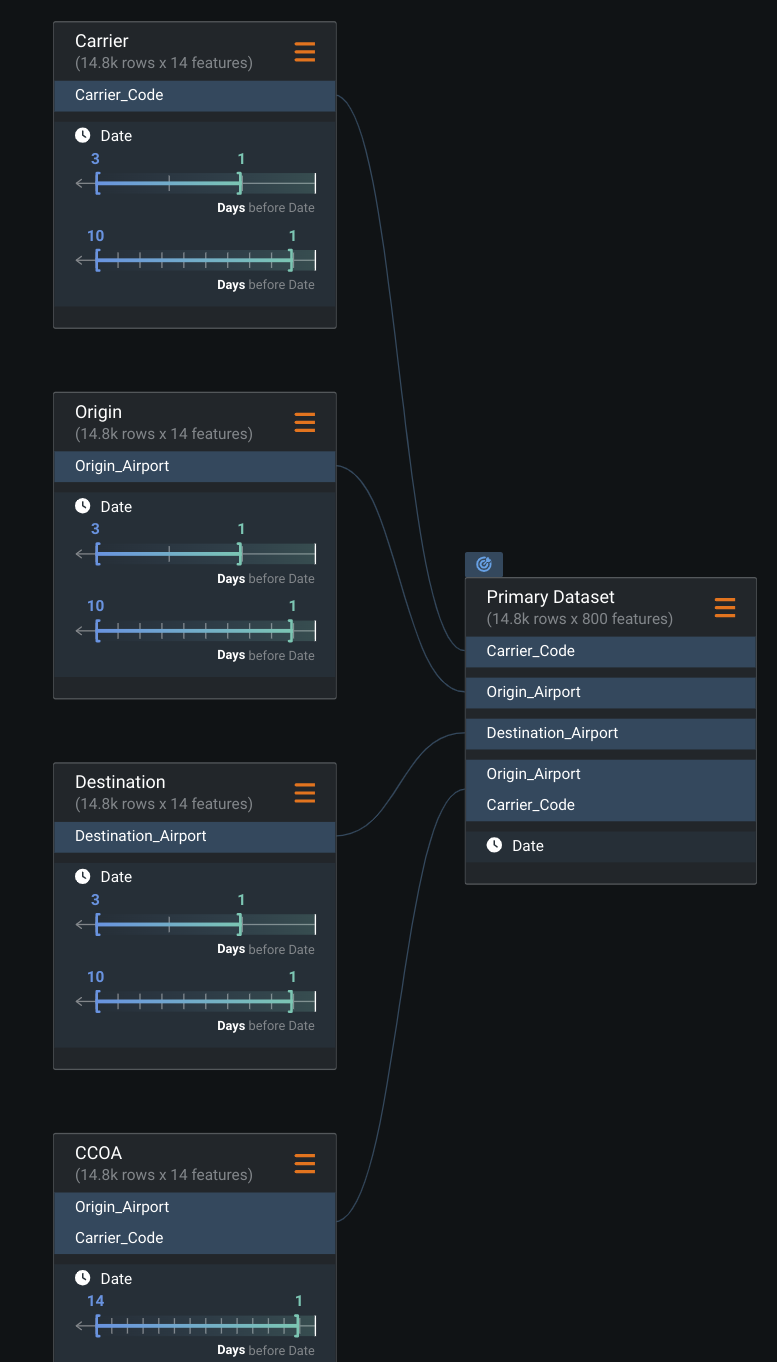

### Start modeling

The project is ready to be started. There are numerous configurable settings shown in the next two cells which are out of scope for this notebook. Visit the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/index.html) to learn more about advanced options, modeling modes, worker counts and selecting an optimization metric.

In [21]:
# These two advanced options will speed up the Autopilot run
# Stop the model competition before creating blenders (also called ensemble models)
# Don't require that a model be prepared for deployment until after you examine the results

advanced_options = dr.AdvancedOptions(
    blend_best_models=False, prepare_model_for_deployment=False
)

In [ ]:
# Start modeling
# Once you execute this cell, the initial settings can no longer be changed
# Note the inclusion of the correct featurelist_id for only the Known features
# Note the inclusion of the relationships_configuration_id

project.analyze_and_model(
    target="Take_Off_Delay_30",
    mode=dr.AUTOPILOT_MODE.FULL_AUTO,
    metric="LogLoss",
    featurelist_id=primary_featurelist_id,
    relationships_configuration_id=relationship_config.id,
    feature_engineering_prediction_point="Date",
    advanced_options=advanced_options,
    worker_count=-1,
)  # Entering -1 uses all available workers

# Setting timeout=None as the feature engineering and reduction for this dataset is extensive
project.wait_for_autopilot(timeout=60 * 60 * 4)

In [24]:
?project.wait_for_autopilot

Signature:
project.wait_for_autopilot(
    check_interval: 'Union[float, int]' = 20.0,
    timeout: 'Optional[Union[float, int]]' = 86400,
    verbosity: 'Union[int, VERBOSITY_LEVEL]' = 1,
) -> 'None'
Docstring:
Blocks until autopilot is finished. This will raise an exception if the autopilot
mode is changed from AUTOPILOT_MODE.FULL_AUTO.

It makes API calls to sync the project state with the server and to look at
which jobs are enqueued.

Parameters
----------
check_interval : float or int
    The maximum time (in seconds) to wait between checks for whether autopilot is finished
timeout : float or int or None
    After this long (in seconds), we give up. If None, never timeout.
verbosity:
    This should be VERBOSITY_LEVEL.SILENT or VERBOSITY_LEVEL.VERBOSE.
    For VERBOSITY_LEVEL.SILENT, nothing will be displayed about progress.
    For VERBOSITY_LEVEL.VERBOSE, the number of jobs in progress or queued is shown.
    Note that new jobs are added to the queue along the way.

Raises
----

## Examine newly created features

In this section, retrieve an examine the list of features post feature-engineering.

In [3]:
# project = dr.Project.get('646c0eaa6c20cb10cb228e16') #since the prior cell could take a long time to run, you might want to re-start from this point by entering an existing project ID

In [4]:
# Retrieve all features available at this point and count them
all_features = project.get_features()
len(all_features)

731

In [5]:
# Inspect 20 random feature names

for x in range(20):
    print(random.choice(all_features))

Feature(Carrier[Taxi_Out_Time] (2 days avg by Origin_Airport=PDX))
Feature(Origin[Take_Off_Delay_Minutes] (9 days kurtosis))
Feature(Destination[Carrier_Code] (2 days entropy))
Feature(Destination[Delay_Weather] (9 days skewness))
Feature(Origin[Take_Off_Delay_Minutes] (9 days max by Carrier_Code=HA))
Feature(Origin[Take_Off_Delay_Minutes] (9 days max by Carrier_Code=UA))
Feature(Origin[Delay_Carrier] (9 days std))
Feature(Carrier[Take_Off_Delay_Minutes] (2 days min))
Feature(Carrier[Taxi_Out_Time] (9 days kurtosis))
Feature(Carrier[Delay_Carrier] (9 days max by Origin_Airport=SFO))
Feature((Origin[Take_Off_Delay_Minutes] (2 days sum by Carrier_Code=HA)) DIVIDED BY (Origin[Take_Off_Delay_Minutes] (9 days sum by Carrier_Code=HA)))
Feature(Delay_Late_Aircraft_Arrival)
Feature(Carrier[Take_Off_Delay_Minutes] (9 days median))
Feature(CCOA[Destination_Airport] (13 days counts))
Feature(Destination[Delay_Carrier] (9 days avg by Carrier_Code=UA))
Feature(Carrier[Take_Off_Delay_Minutes] (9 day

## Analyze accuracy in the top-performing model

Retrieve the top model and compare it to a reference model created without the self-join method.

In [6]:
# Get all the models for the project. The top model for the optimization metric on the validation set is the first one.
models = project.get_models()
top_model = models[0]

In [7]:
# Print the LogLoss and AUC for the top model
f"The top model is a {top_model.model_type} with a Log Loss of {top_model.metrics['LogLoss']['crossValidation']} and an AUC of {top_model.metrics['AUC']['crossValidation']}."

'The top model is a eXtreme Gradient Boosted Trees Classifier with Early Stopping with a Log Loss of 0.534656 and an AUC of 0.7224519999999999.'

Not shown in this notebook is the creation of the reference project that does not use self-joins. The next cell retrieves the metrics for that project. The version with self-joins is more accurate.

In [9]:
# reference_project_id = '645ec3c53459f18e0645122b'
# reference_project = dr.Project.get(reference_project_id)
# reference_top_model = reference_project.get_top_model(metric="LogLoss")

# #Print the LogLoss and AUC for the top model
# f"The top model is a {reference_top_model.model_type} with a Log Loss of {reference_top_model.metrics['LogLoss']['crossValidation']} and an AUC of {reference_top_model.metrics['AUC']['crossValidation']}."
print(
    "The top model is a RandomForest Classifier (Gini) with a Log Loss of 0.550994 and an AUC of 0.694954."
)

The top model is a RandomForest Classifier (Gini) with a Log Loss of 0.550994 and an AUC of 0.694954.


## Get Feature Impact

Look specifically at the top model in the self-joins project to see what features are included. It turns out that almost all the features created are being used in the model which is often undesirable. This notebook offers simple method for reducing the number of features based on a threshold feature impact value. It is noteworthy that 80 different features are contributing 1% or more. 

Continuing to improve the accuracy of the top model through further feature reduction is out of scope for this notebook, but would be the typical next step.

In [10]:
# Get Feature Impact for the top model
feature_impact = top_model.get_or_request_feature_impact(max_wait=60 * 60)

# Save Feature Impact in the Pandas DataFrame
fi_df = pd.DataFrame(feature_impact)

fi_df

,featureName,impactNormalized,impactUnnormalized,redundantWith
0,Scheduled_Departure_Time,1.000000,0.056544,None
1,Origin[Tail_Number] (9 days counts),0.187801,0.010619,None
2,CCOA[Tail_Number] (13 days counts),0.143865,0.008135,None
3,Tail_Number,0.078656,0.004447,None
4,Origin[Tail_Number] (2 days counts),0.071728,0.004056,None
...,...,...,...,...
715,CCOA[Delay_Security] (13 days counts),-0.000784,-0.000044,None
716,Destination[Delay_Carrier] (9 days max),-0.000828,-0.000047,None
717,Origin[Take_Off_Delay_Minutes] (9 days max by ...,-0.000833,-0.000047,None
718,Carrier[Flight_Number] (2 days kurtosis),-0.001154,-0.000065,None


In [18]:
f"{len(fi_df)} of the {len(all_features)} features are used by the model. Feature reduction techniques will help improve prediction latency and interpretability and are beyond the scope of this notebook"

'720 of the 731 features are used by the model. Feature reduction techniques will help improve prediction latency and interpretability and are beyond the scope of this notebook'

One approach is to use Feature Importance Rank Ensembling (FIRE) which is covered in a different DataRobot AI Accelerator. The FIRE method uses the rank of features across multiple blueprints to identify the ones that are consistently important and is definitely worth learning about. Techniques for reducing long feature lists are out of scope for this notebook. 

For a quick comparison, we will retrain the top model using features that contribute over 2% to permutation based feature importance.

In [11]:
# Count how many features contribute 1% or more
sum(fi_df["impactNormalized"] > 0.01)

91

In [12]:
# Count how many features contribute 2% or more. We'll use this smaller subset.
sum(fi_df["impactNormalized"] > 0.02)

37

In [13]:
# Create a reduced feature list from features with a 2% or greater feature importance and retrain the top model
n = sum(fi_df["impactNormalized"] > 0.02)
fi = fi_df.head(n)  # get feature names of top n features
new_fl = project.create_featurelist(
    "M{} top {}".format(top_model.model_number, n),  # create a new feature list
    fi["featureName"].tolist(),
)
reduced_model_job = top_model.retrain(
    featurelist_id=new_fl.id
)  # start a retraining job on the top_model with the reduced feature list
reduced_model = reduced_model_job.get_result_when_complete(max_wait=60 * 60)

reduced_model.cross_validate()  # run cross validation

In [20]:
reduced_model = dr.Model.get(project.id, reduced_model.id)
f"The top model with reduced features has a Log Loss of {reduced_model.metrics['LogLoss']['crossValidation']} and an AUC of {reduced_model.metrics['AUC']['crossValidation']},compared to the full top model with the full feature list and a Log Loss of {top_model.metrics['LogLoss']['crossValidation']} and an AUC of {top_model.metrics['AUC']['crossValidation']}."

'The top model with reduced features has a Log Loss of 0.537334 and an AUC of 0.7175459999999999,compared to the full top model with the full feature list and a Log Loss of 0.534656 and an AUC of 0.7224519999999999.'

In [22]:
# Print the top 20 features
for feature in fi_df["featureName"][0:20]:
    print(feature)

Scheduled_Departure_Time
Origin[Tail_Number] (9 days counts)
CCOA[Tail_Number] (13 days counts)
Tail_Number
Origin[Tail_Number] (2 days counts)
Destination[Tail_Number] (9 days counts)
Destination[Take_Off_Delay_30] (2 days counts)
Flight_Number
Destination[Taxi_Out_Time] (2 days std)
Destination[Delay_National_Aviation_System] (2 days kurtosis)
Destination[Tail_Number] (2 days most frequent)
Destination[Flight_Number] (2 days min)
Destination[Take_Off_Delay_Minutes] (2 days kurtosis)
Carrier[Tail_Number] (2 days counts)
Destination[Flight_Number] (2 days latest)
Destination[Take_Off_Delay_Minutes] (2 days latest)
Destination[Date] (days from Destination[Scheduled_Departure_Time]) (2 days std)
Destination[Delay_Security] (9 days counts)
Destination[Taxi_Out_Time] (2 days latest)
Destination[Flight_Number] (9 days skewness)


Some of these features are extremely detailed and may be aggregations that the team working on the problem would not have thought of. But, the __real effectiveness of self-joins is in the time saved__. Even if the team did think of all these aggregations, coding each of the 800 features is extremely laborious.

If the feature names are hard to decipher, then go to the DataRobot UI for the project where you can see a lineage chart that depicts the origin of each feature.

For example:

* `Origin[Tail_Number] (9 days counts)` means "In the last 9 days, which specific planes have been at the origina airport, and how many times"? (returned as a JSON list)

* `Origin[Tail_Number] (9 days most frequent)` means "In the last 9 days, which specific plane has been at the origina airport the most"?

* `Origin[Take_Off_Delay_Minutes] (2 days avg by Carrier_Code=AA)` means "In the last two days, what is the avearge total delay in minutes for all American Airlines flights?"

* `Destination[Take_Off_Delay_Minutes] (9 days median)` means "In the last 9 days, what is the 50th percentile (median) take off delay in minutes associated with the destination airport?"


## Conclusion

This notebook demonstrates that __self-joins can lead to improved model performance__ and __self joins are easy to set up in DataRobot__.

The self-join technique should always be considered when working with panel data that contains observations for the same subject over time.

When building predictive models from panel data, the model can often be substantially improved by including engineered features which capture time-based patterns within the panel feature(s). The extent to which this technique will improve accuracy for any specific use case requires experimentation and cannot be known at the outset.